In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error as mape,mean_absolute_error as mae
from keras import optimizers

# Prepare Data

In [2]:
cloud_cover = pd.read_csv(r"G:\My Drive\senior\mergefile_drop_na.csv",skipinitialspace = True)
cloud_cover = cloud_cover.rename(columns={"timestamp":"DateTime"})
cloud_cover

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


In [3]:
cloud_cover = cloud_cover.drop(columns=['Eeg'])

In [4]:
def lags_train_test(datax, datay, data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(datax[i-lags:i])
		y.append(datay[i])
	return np.array(X), np.array(y)

In [16]:
def Xtrain_ytrain(train,test,lags):
    sc = MinMaxScaler()
    train_x = sc.fit_transform(train)
    sc1 = MinMaxScaler()
    train_y = sc1.fit_transform(train[['cloud_cover']])
    # train
    X_train, y_train = lags_train_test(train_x,train_y, train, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    columns = test[['Temperature','RH','Windspeed','cloud_cover']]
    dataset_total = pd.concat(([train,test]), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = pd.DataFrame(inputs, columns=columns.columns)
    test_x = sc.transform(inputs)
    test_y = sc1.transform(inputs[['cloud_cover']])
    # test
    X_test, y_test = lags_train_test(test_x,test_y, inputs, lags)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc1

In [17]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [18]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [19]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# Train/Test Model

In [20]:
train,test = train_test_split(cloud_cover, train_size=0.8, shuffle=False)
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (2384, 5)
Test Shape (596, 5)


In [21]:
train

,DateTime,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...
2379,2021-12-10 14:45:00,30.9634,47.6566,1.7682,0.585000
2380,2021-12-10 14:50:00,30.8892,47.8534,1.8098,0.582000
2381,2021-12-10 14:55:00,30.9140,47.4738,1.7394,0.453000
2382,2021-12-10 15:00:00,30.7786,47.5446,1.6592,0.595000


In [22]:
test

,DateTime,Temperature,RH,Windspeed,cloud_cover
2384,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601
2385,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654
2386,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588
2387,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577
2388,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554
...,...,...,...,...,...
2975,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185
2976,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182
2977,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180
2978,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169


In [23]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

In [24]:
train

,Temperature,RH,Windspeed,cloud_cover
DateTime,,,,
2021-11-16 11:15:00,29.3306,68.9674,1.7412,0.990000
2021-11-16 11:20:00,29.2626,69.6372,1.7202,0.989667
2021-11-16 11:25:00,29.2746,70.6488,1.7378,0.993667
2021-11-16 11:30:00,29.2650,70.6084,1.6944,0.987500
2021-11-16 11:35:00,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...
2021-12-10 14:45:00,30.9634,47.6566,1.7682,0.585000
2021-12-10 14:50:00,30.8892,47.8534,1.8098,0.582000
2021-12-10 14:55:00,30.9140,47.4738,1.7394,0.453000


## Lag 5

In [25]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (2379, 5, 4)
y_train Shape : (2379, 1)
X_test Shape :  (596, 5, 4)
y_test Shape :  (596, 1)


### Add frist layer: units = 100

In [26]:
model_1 = Sequential()
model_1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
model_1.add(Dense(units = 1))
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, batch_size = 32)

Epoch 1/20
75/75 [==============================] - 6s 13ms/step - loss: 0.0434 - val_loss: 0.0117
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 3/20
75/75 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/20
75/75 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 6/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 8/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 9/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 10/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 11/20
75/75 

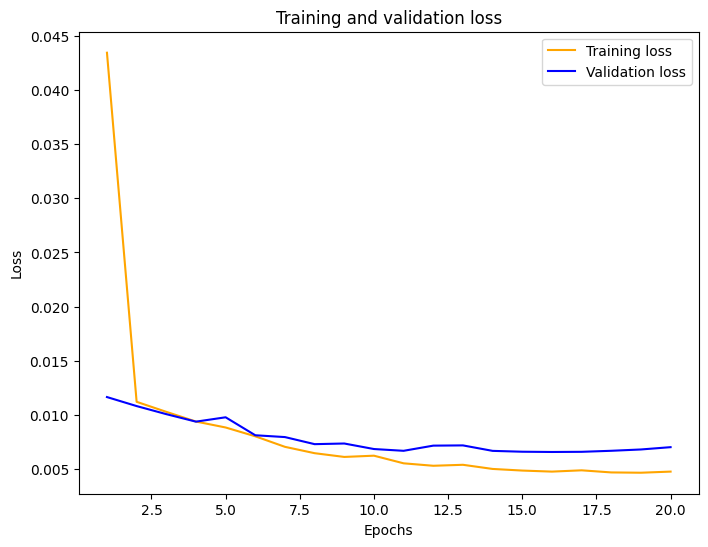

In [27]:
plot_curve(hist)

In [28]:
predict_scaled = model_1.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

19/19 [==============================] - 0s 3ms/step


array([[0.61069477],
       [0.57153165],
       [0.61919075],
       [0.5601445 ],
       [0.54416895],
       [0.5259713 ],
       [0.51324016],
       [0.49365735],
       [0.46921313],
       [0.5474209 ],
       [0.5538731 ],
       [0.42389748],
       [0.4628662 ],
       [0.29167083],
       [0.29658157],
       [0.34179884],
       [0.27755603],
       [0.20159528],
       [0.26471192],
       [0.20709057],
       [0.17357716],
       [0.1482636 ],
       [0.6964957 ],
       [0.8627885 ],
       [0.8921135 ],
       [0.7876942 ],
       [0.8210076 ],
       [0.77843994],
       [0.8222099 ],
       [0.8382061 ],
       [0.75384367],
       [0.75683254],
       [0.820101  ],
       [0.86052793],
       [0.6859884 ],
       [0.6508302 ],
       [0.61132926],
       [0.6423159 ],
       [0.6874758 ],
       [0.55624884],
       [0.5630839 ],
       [0.5903387 ],
       [0.5433132 ],
       [0.6194766 ],
       [0.6378791 ],
       [0.6925616 ],
       [0.836011  ],
       [0.856

In [29]:
train0 = train.copy()
test0 = test.copy()

In [30]:
train0.reset_index(inplace=True)
test0.reset_index(inplace=True)

In [31]:
test0['LSTM'] = predict
test0

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.610695
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.571532
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.619191
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.560144
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.544169
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.164581
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.170022
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.167403
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.166271


In [32]:
plot_test(train0,test0)

In [33]:
lstm_mae_error = mae(test0["cloud_cover"], test0["LSTM"])
lstm_mape_error = mape(test0["cloud_cover"], test0["LSTM"])
lstm_mse_error = mean_squared_error(test0['cloud_cover'], test0['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test0["cloud_cover"], test0["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error)
print('MAPE Error :  %.5f'%lstm_mape_error)
print('MSE Error : %.5f'%lstm_mse_error)
print('RMSE Error :  %.5f'%lstm_rmse_error)

MAE Error :  0.05076
MAPE Error :  0.18229
MSE Error : 0.00696
RMSE Error :  0.08345


---

## Lag 10

In [34]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train,test,10)

X_train Shape : (2374, 10, 4)
y_train Shape : (2374, 1)
X_test Shape :  (596, 10, 4)
y_test Shape :  (596, 1)


### Add frist layer units = 50 batch size 32  epochs 10

In [35]:
model_2 = Sequential()
model_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1],X_train1.shape[2])))
model_2.add(Dense(units = 1))
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist1 = model_2.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 20, batch_size = 32)

Epoch 1/20
75/75 [==============================] - 3s 13ms/step - loss: 0.0607 - val_loss: 0.0150
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0141 - val_loss: 0.0131
Epoch 3/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 4/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 5/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 6/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 7/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 8/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 9/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 10/20
75/75 [==============================] - 1s 8ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 11/20
75/75 

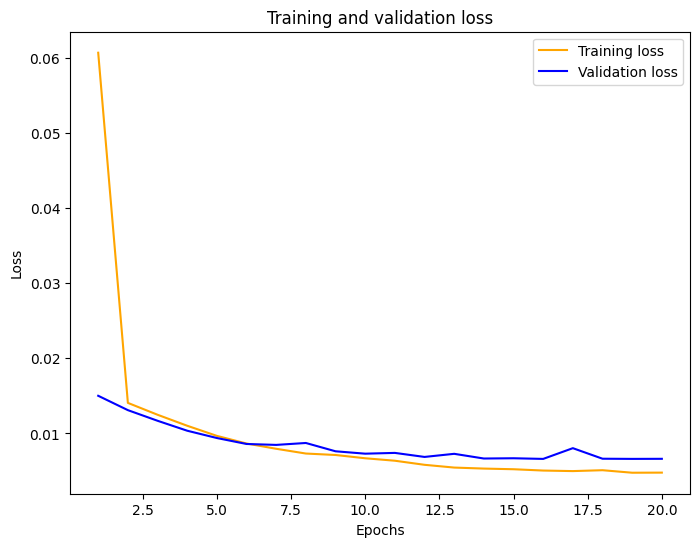

In [36]:
plot_curve(hist1)

In [37]:
predict_scaled1 = model_2.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)

19/19 [==============================] - 0s 4ms/step


In [38]:
test1 = test.copy()
train1 = train.copy()

In [39]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [40]:
test1['LSTM'] = predict1
test1

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.634296
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.606563
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.640925
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.591478
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.569293
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.188961
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.191003
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.188935
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.188490


In [41]:
plot_test(train1,test1)

In [42]:
lstm_mae_error1 = mae(test1["cloud_cover"], test1["LSTM"])
lstm_mape_error1 = mape(test1["cloud_cover"], test1["LSTM"])
lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error1 = mean_squared_error(test1["cloud_cover"], test1["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error1)
print('MAPE Error :  %.5f'%lstm_mape_error1)
print('MSE Error : %.5f'%lstm_mse_error1)
print('RMSE Error :  %.5f'%lstm_rmse_error1)

MAE Error :  0.04762
MAPE Error :  0.20244
MSE Error : 0.00655
RMSE Error :  0.08096


---

## Lag 15

In [43]:
# X_train, y_train, X_test and y_test
X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train,test,15)

X_train Shape : (2369, 15, 4)
y_train Shape : (2369, 1)
X_test Shape :  (596, 15, 4)
y_test Shape :  (596, 1)


### Optimizer adam first layer 50 drop 0.1 second layer50 batch size 32 epochs 10 lr 0.005

In [44]:
model_3 = Sequential()
model_3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train2.shape[1],X_train2.shape[2])))
model_3.add(Dropout(0.1))
model_3.add(LSTM(units = 50))
model_3.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_3.compile(optimizer = opt, loss = 'mean_squared_error')
hist2 = model_3.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 5s 23ms/step - loss: 0.0257 - val_loss: 0.0115
Epoch 2/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0112 - val_loss: 0.0086
Epoch 3/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 4/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 5/10
75/75 [==============================] - 1s 14ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 6/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 7/10
75/75 [==============================] - 1s 14ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 8/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 9/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 10/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0097


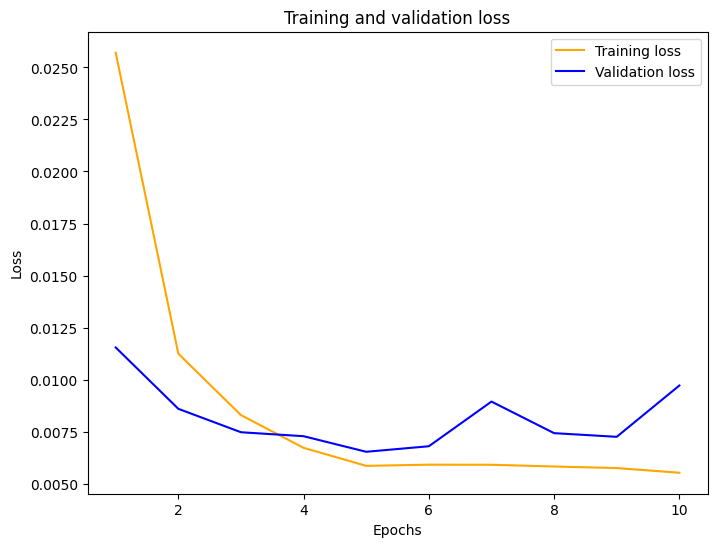

In [45]:
plot_curve(hist2)

In [46]:
predict_scaled2 = model_3.predict(X_test2)
predict2 = sc2.inverse_transform(predict_scaled2)

19/19 [==============================] - 1s 5ms/step


In [47]:
train2 = train.copy()
test2 = test.copy()

In [48]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [49]:
test2['LSTM'] = predict2
test2

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.570635
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.532824
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.573976
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.511632
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.504360
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.139739
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.143200
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.139550
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.138741


In [50]:
plot_test(train2,test2)

In [51]:
lstm_mae_error2 = mae(test2["cloud_cover"], test2["LSTM"])
lstm_mape_error2 = mape(test2["cloud_cover"], test2["LSTM"])
lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
lstm_rmse_error2 = mean_squared_error(test2["cloud_cover"], test2["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error2)
print('MAPE Error :  %.5f'%lstm_mape_error2)
print('MSE Error : %.5f'%lstm_mse_error2)
print('RMSE Error :  %.5f'%lstm_rmse_error2)

MAE Error :  0.07255
MAPE Error :  0.30476
MSE Error : 0.00962
RMSE Error :  0.09807


---

## Lag 20

In [52]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train,test,20)

X_train Shape : (2364, 20, 4)
y_train Shape : (2364, 1)
X_test Shape :  (596, 20, 4)
y_test Shape :  (596, 1)


### Optimizer adam first layer 50 batch size 32 epochs 10 lr 0.005

In [53]:
model_4 = Sequential()
model_4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1],X_train3.shape[2])))
model_4.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_4.compile(optimizer = opt, loss = 'mean_squared_error')
hist3 = model_4.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32)

Epoch 1/10
74/74 [==============================] - 3s 14ms/step - loss: 0.0260 - val_loss: 0.0101
Epoch 2/10
74/74 [==============================] - 1s 8ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 3/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 4/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 5/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 6/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 7/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 8/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.0070
Epoch 9/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 10/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0075


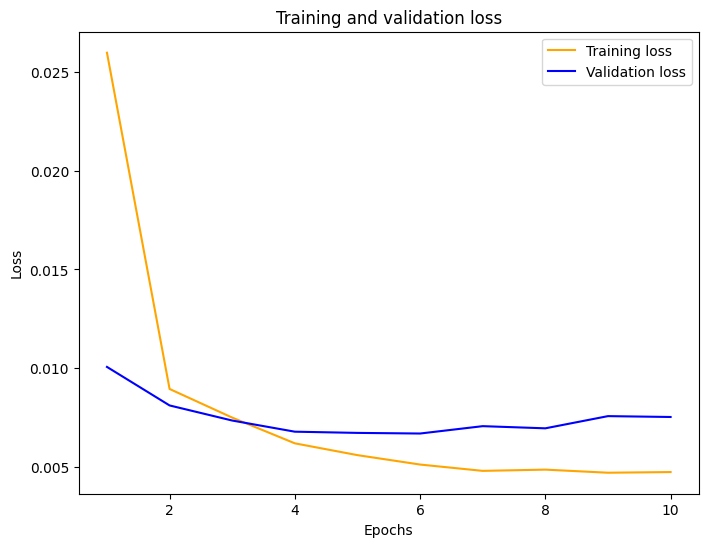

In [54]:
plot_curve(hist3)

In [55]:
predict_scaled3 = model_4.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

19/19 [==============================] - 0s 3ms/step


In [56]:
train3 = train.copy()
test3 = test.copy()

In [57]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [58]:
test3['LSTM'] = predict3
test3

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.667655
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.623120
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.670398
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.603749
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.591355
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.207268
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.212726
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.207773
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.207807


In [59]:
plot_test(train3,test3)

In [60]:
lstm_mae_error3 = mae(test3["cloud_cover"], test3["LSTM"])
lstm_mape_error3 = mape(test3["cloud_cover"], test3["LSTM"])
lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
lstm_rmse_error3 = mean_squared_error(test3["cloud_cover"], test3["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error3)
print('MAPE Error :  %.5f'%lstm_mape_error3)
print('MSE Error : %.5f'%lstm_mse_error3)
print('RMSE Error :  %.5f'%lstm_rmse_error3)

MAE Error :  0.05667
MAPE Error :  0.30851
MSE Error : 0.00747
RMSE Error :  0.08641


---

## Lag 25

In [61]:
# X_train, y_train, X_test and y_test
X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train,test,25)

X_train Shape : (2359, 25, 4)
y_train Shape : (2359, 1)
X_test Shape :  (596, 25, 4)
y_test Shape :  (596, 1)


### Optimizer adam first layer 50 batch size 32 learning rate 0.1 epochs 10 

In [62]:
model_5 = Sequential()
model_5.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train4.shape[1],X_train4.shape[2])))
model_5.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.1)
model_5.compile(optimizer = opt, loss = 'mean_squared_error')
hist4 = model_5.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 10, batch_size = 32)

Epoch 1/10
74/74 [==============================] - 3s 15ms/step - loss: 0.5493 - val_loss: 0.0092
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 3/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 4/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 5/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 8/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 9/10
74/74 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 10/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.0081


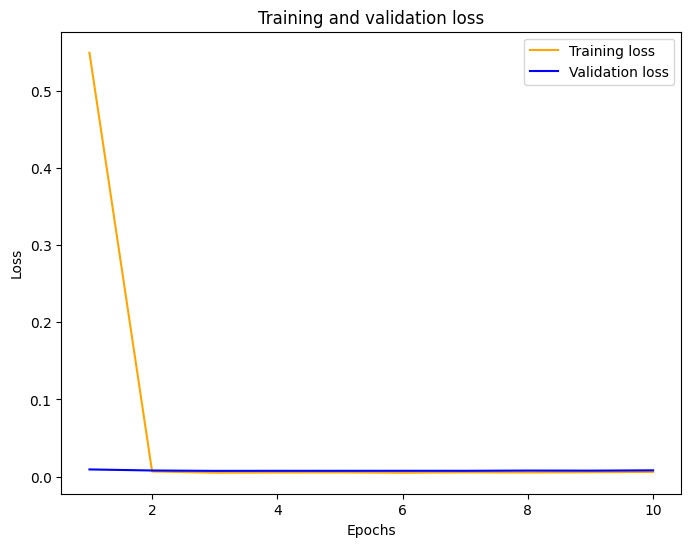

In [63]:
plot_curve(hist4)

In [64]:
predict_scaled4 = model_5.predict(X_test4)
predict4 = sc4.inverse_transform(predict_scaled4)

19/19 [==============================] - 0s 4ms/step


In [65]:
train4 = train.copy()
test4 = test.copy()

In [66]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [67]:
test4['LSTM'] = predict4
test4

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.623038
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.546992
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.639013
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.531239
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.529381
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.156770
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.162844
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.155372
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.156765


In [68]:
plot_test(train4,test4)

In [69]:
lstm_mae_error4 = mae(test4["cloud_cover"], test4["LSTM"])
lstm_mape_error4 = mape(test4["cloud_cover"], test4["LSTM"])
lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
lstm_rmse_error4 = mean_squared_error(test4["cloud_cover"], test4["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error4)
print('MAPE Error :  %.5f'%lstm_mape_error4)
print('MSE Error : %.5f'%lstm_mse_error4)
print('RMSE Error :  %.5f'%lstm_rmse_error4)

MAE Error :  0.05688
MAPE Error :  0.20747
MSE Error : 0.00798
RMSE Error :  0.08935


---

## Lag 30

In [70]:
# X_train, y_train, X_test and y_test
X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train,test,30)

X_train Shape : (2354, 30, 4)
y_train Shape : (2354, 1)
X_test Shape :  (596, 30, 4)
y_test Shape :  (596, 1)


### Add frist layer units = 100 batch size 32  epochs 10 lr 0.005

In [71]:
model_6 = Sequential()
model_6.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train5.shape[1],X_train5.shape[2])))
model_6.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_6.compile(optimizer = opt, loss = 'mean_squared_error')
hist5 = model_6.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 10, batch_size = 32)

Epoch 1/10
74/74 [==============================] - 3s 16ms/step - loss: 0.0228 - val_loss: 0.0091
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 3/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 4/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 5/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 8/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0078
Epoch 9/10
74/74 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 10/10
74/74 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0068


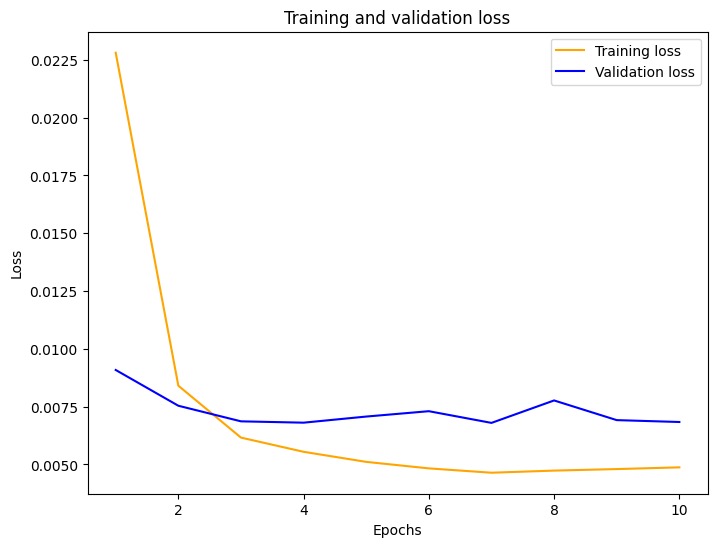

In [72]:
plot_curve(hist5)

In [73]:
predict_scaled5 = model_6.predict(X_test5)
predict5 = sc5.inverse_transform(predict_scaled5)

19/19 [==============================] - 0s 4ms/step


In [74]:
train5 = train.copy()
test5 = test.copy()

In [75]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [76]:
test5['LSTM'] = predict5
test5

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-10 15:15:00,30.62860,49.2608,1.6896,0.601,0.636325
1,2021-12-10 15:20:00,30.41125,50.1080,1.7555,0.654,0.587406
2,2021-12-10 15:25:00,30.81500,49.5100,1.7740,0.588,0.642449
3,2021-12-10 15:30:00,30.50740,50.0562,1.6948,0.577,0.573978
4,2021-12-10 15:35:00,30.35780,50.8378,1.7424,0.554,0.564469
...,...,...,...,...,...,...
591,2021-12-16 13:40:00,32.06380,38.0598,1.7466,0.185,0.174238
592,2021-12-16 13:45:00,32.39060,37.1100,1.7442,0.182,0.180957
593,2021-12-16 13:50:00,32.34440,37.1282,1.7116,0.180,0.176873
594,2021-12-16 13:55:00,32.39440,37.2276,1.7612,0.169,0.175572


In [77]:
plot_test(train5,test5)

In [78]:
lstm_mae_error5 = mae(test5["cloud_cover"], test5["LSTM"])
lstm_mape_error5 = mape(test5["cloud_cover"], test5["LSTM"])
lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
lstm_rmse_error5 = mean_squared_error(test5["cloud_cover"], test5["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error5)
print('MAPE Error :  %.5f'%lstm_mape_error5)
print('MSE Error : %.5f'%lstm_mse_error5)
print('RMSE Error :  %.5f'%lstm_rmse_error5)

MAE Error :  0.04832
MAPE Error :  0.21125
MSE Error : 0.00677
RMSE Error :  0.08228


---

# error

## avg mae

In [79]:
avgmse = (lstm_mae_error+lstm_mae_error1+lstm_mae_error2+lstm_mae_error3+lstm_mae_error4+lstm_mae_error5)/6
print("AVG MAE : %.5f"%avgmse)

AVG MAE : 0.05547


---

## avg mape

In [80]:
avgmape = (lstm_mape_error+lstm_mape_error1+lstm_mape_error2+lstm_mape_error3+lstm_mape_error4+lstm_mape_error5)/6
print("AVG MAPE : %.5f"%avgmape)

AVG MAPE : 0.23612


---

## avg mse

In [81]:
avgmse = (lstm_mse_error+lstm_mse_error1+lstm_mse_error2+lstm_mse_error3+lstm_mse_error4+lstm_mse_error5)/6
print("AVG MSE :%.5f"%avgmse)

AVG MSE :0.00756


---

## avg rmse

In [82]:
avgrmse = (lstm_rmse_error+lstm_rmse_error1+lstm_rmse_error2+lstm_rmse_error3+lstm_rmse_error4+lstm_rmse_error5)/6
print("AVG RMSE : %.5f"%avgrmse)

AVG RMSE : 0.08675


---

---